In [1]:
import librosa
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
#from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from scipy.signal import ShortTimeFFT, windows

# Verificar si CUDA está disponible y configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def data_read(data_folder, samplerate = 48000):
  # vemos los archivos de audio
  # carpeta del training set

  classes_folders = os.listdir(data_folder)
  # Creamos un diccionario para cada clase donde pondremos los audios
  data = {}
  for c in classes_folders:
     if c[0] != '.':
          data[c] = data.get(c, []) # agregamos

  # Llenamos una lista para cada clase con los datos
  for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=samplerate)  # leemos el audio como numpy array
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales
  return data

In [3]:
SR = 48000
data_folder = os.path.join('.','series_temporales_maxi','trabajo_final','src','audios')
data = data_read(data_folder,samplerate=SR)
# Inspección de los datos
print("TRAIN & VALIDATION DATA")
for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

data.pop('colectivo')
data.pop('moto')
data.pop('auto')
data.pop('camioneta')
train = {}
test = {}
train['silencio'] = data['silencio'][:25]
test['silencio']= data['silencio'][25:]
train['vehic'] = data['vehic'][:25]
test['vehic'] = data['vehic'][25:]

TRAIN & VALIDATION DATA
La clase colectivo tiene 20 elementos
La clase silencio tiene 30 elementos
La clase moto tiene 12 elementos
La clase auto tiene 16 elementos
La clase camioneta tiene 12 elementos
La clase vehic tiene 60 elementos


In [4]:
from sklearn.preprocessing import LabelEncoder
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(ws), hop=ws, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()
    return SFT.f, ts[::ws], Sx.T  # ax 0: time ax 1: freqs

def create_serie(x, width, ws, sr):
    '''
    returns a series of spectrograms of width= width
    this series can be used as time series for a lstm
    '''
    f, ts, spec = create_specs(x, ws, sr)
    serie = []
    for i in range(spec.shape[0]//width):
        serie.append(spec[i*width:i*width+width])
    return np.array(serie),spec

def  create_serie_list(data, IMG_WIDTH, SPECT_WS, SR):
  stft_serie={}
  stft={}
  label_list=[]
  for k, values in data.items():
    stft[k]=[]
    stft_serie[k]=[]
    for v in values:
        label_list.append(k)
        serie,spect=create_serie(v, width=IMG_WIDTH, ws=SPECT_WS, sr = SR)
        #serie = np.array(serie)
        stft_serie[k].append(serie)
        stft[k].append(spect)
  labels = list(data.keys())
  enc = LabelEncoder()
  enc.fit(labels)
  label_list = enc.transform(np.array(label_list)).reshape(-1,1)
  return stft_serie,stft,label_list

In [5]:
width_serie = 1
amp = 800
stft_serie,stft_spect,labels = create_serie_list(train, IMG_WIDTH=width_serie, SPECT_WS=amp, SR=SR)
stft_serie_test,stft_spect_test,test_label = create_serie_list(test, IMG_WIDTH=width_serie, SPECT_WS=amp, SR=SR)

/tmp/ipykernel_3471572/366312724.py:9: RuntimeWarning: divide by zero encountered in log
  Sx_l = np.log(Sx[:])
/tmp/ipykernel_3471572/366312724.py:10: RuntimeWarning: invalid value encountered in subtract
  Sx = (Sx_l - Sx_l.min())
/tmp/ipykernel_3471572/366312724.py:9: RuntimeWarning: divide by zero encountered in log
  Sx_l = np.log(Sx[:])
/tmp/ipykernel_3471572/366312724.py:10: RuntimeWarning: invalid value encountered in subtract
  Sx = (Sx_l - Sx_l.min())


In [6]:
class SimpleLSTM(torch.nn.Module):
    def __init__(self, w, h, categories):
        super().__init__()
        self.w = w
        self.h = h
        self.categories = categories
        self.dr = 0.3
        self.lstm = torch.nn.LSTM(input_size=w, hidden_size=64, num_layers=h, batch_first=True, dropout=self.dr)
        self.linear = torch.nn.Linear(in_features=64, out_features=self.categories)
        self.relu = torch.nn.ReLU()

    def forward(self,x):
        #********LSTM********#
        x, _ = self.lstm(x)
        x = self.linear(x)
        return self.relu(x[-1])

In [7]:
lstm = SimpleLSTM(401, 1, 2).to(device)

/home/sebastian/Documents/Codes/Traffic-Maxi/MAXIABDALA/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


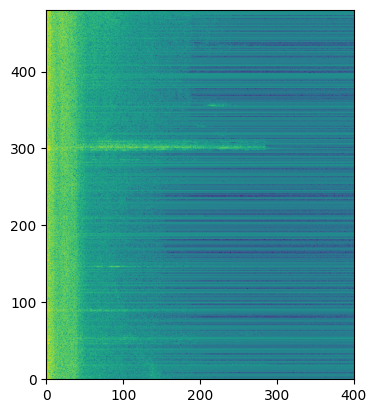

In [8]:
plt.imshow(stft_spect['silencio'][0], origin='lower')

In [9]:
lstm(torch.FloatTensor(stft_spect['vehic'][0]).cuda())

tensor([0.0000, 0.0235], device='cuda:0', grad_fn=<ReluBackward0>)

In [10]:
# Definir hiperparámetros
learning_rate = 0.001# no es necesario con adadelta
num_epochs = 20

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), learning_rate)

In [11]:
from sklearn.metrics import accuracy_score

def train_model(model, train, val, labels_t, labels_v, criterion, optimizer, num_epochs):
    history = []
    history_test = []
    history_acc = []
    best_test_acc = 0
    filename = './best_model_params.pth'

    for e in range(num_epochs):
        aux_loss = 0
        model.train()

        for i in range(len(train)):
            print(train[i])
            x = train[i].to(device)
            y_true = torch.tensor(labels_t[i]).to(device)  # Etiquetas como tensor 1D

            y_pred = model(x).view(1, -1)
            loss = criterion(y_pred, y_true)

            optimizer.zero_grad()   # Poner en 0 los gradientes
            loss.backward()         # Calcular las derivadas respecto a los parámetros
            optimizer.step()        # Actualizar los parámetros

            aux_loss += loss.item()

        aux_loss /= len(train)
        history.append(aux_loss)

        with torch.no_grad():
            model.eval()
            val_loss = 0
            preds = []

            for i in range(len(val)):
                x = val[i].to(device)
                y_pred = model(x).view(1, -1)
                val_loss += criterion(y_pred, torch.tensor(labels_v[i]).to(device)).item()
                preds.append(y_pred.cpu().numpy().argmax())

            val_loss /= len(val)
            history_acc.append(accuracy_score(labels_v, preds))
            history_test.append(val_loss)

            if history_acc[-1] > best_test_acc:
                torch.save(model.state_dict(), filename)
                best_test_acc = history_acc[-1]

            if e % 10 == 0:
                print(f'epoch: {e} - validation accuracy score: {history_acc[-1]}')
                print(f'epoch: {e} - training loss: {aux_loss} - test loss: {val_loss}')

    # Graficar resultados
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].semilogy(history, label='training loss')
    axs[0].semilogy(history_test, label='validation loss')
    axs[0].legend()

    axs[1].plot(history_acc, label='validation accuracy score')
    axs[1].legend()

    plt.show()

In [15]:
train_specs_silencio = [torch.FloatTensor(coco).view(1,-1,401) for coco in stft_spect['silencio']]
train_specs_vehic = [torch.FloatTensor(coco).view(1,-1,401) for coco in stft_spect['vehic']]
train_specs = train_specs_silencio
train_specs.append(train_specs_vehic)

In [24]:
train_specs[0]

tensor([[[0.7658, 0.8638, 0.9226,  ..., 0.4265, 0.4405, 0.4114],
         [0.8289, 0.7897, 0.9043,  ..., 0.4402, 0.4420, 0.4270],
         [0.7462, 0.7986, 0.9191,  ..., 0.3525, 0.3905, 0.3928],
         ...,
         [0.8348, 0.8715, 0.8805,  ..., 0.4619, 0.4557, 0.4644],
         [0.8274, 0.9304, 0.8129,  ..., 0.4781, 0.4869, 0.4898],
         [0.8520, 0.8261, 0.8850,  ..., 0.4801, 0.4979, 0.4921]]])

In [22]:
train_model(lstm, train_specs, train_specs, labels, labels, criterion, optimizer, num_epochs=100)

AttributeError: 'list' object has no attribute 'to'